# Bayesian spatial-temporal interaction model for Covid-19

## Joint Work by the Dep. of Neuroinformatics Osnabrück University and the Jülich Super computing Center

<!--- Aktuelle Daten und Vorhersage der Neuinfizierungen mit COVID-19 für 25 Städte in Deutschland. Das Model beschreibt die Tages aktullen Daten basierend auf Daten des RKI  
<a href=" https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0/data?orderBy=Meldedatum">link (Daten)</a>. 
Das Model ist Bayesian das heist das es die Verteilung der Paramter schätzt und somit für verscheidene mögliche Szenarien die mit der aktuellen Datenlage kompatibel sind die Wahrscheinlichkeit berechnet. 
Dazu sind din der zeitlichen Verläufen die Beobachten Zahlen an Neuinfektionen pro Tag als schwarze Punkte eingezeichnet. Der Verlauf des wahrscheinlichsten Models ist in rot eingezeicghnet und die Konfidenz intervalle mit 25% und 75% mit einen organgen Intervall und einer gepunkteten Line eingezeichnet. -->

Daily updated new infection cases of COVID-19 for 25 cities or counties in Germany. The model uses the daily updates of the <a href=" https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0/data?orderBy=Meldedatum"> database</a> provided by the Robert-Kock institute. The model is Bayesian implying that it models the probability of all with the model compatible outcomes. 
The work presented here is based on an adaptation of the  <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0225838#pone.0225838.ref009">(BSTIM model)</a>. adapted to the COVID-19 outbreak scenario. 

In [13]:
%run ../src/plot_curves_appendix.py
%run ../src/plot_curves.py
%run ../src/plot_interaction_kernel.py
%run ../src/plot_temporal_contribution.py

## Model fit for 25 example counties
For each of the 25 counties the black dots show the reported daily new cases. The most likly model rate of daily new cases is plotted red. The shaded areas indicate the quantiles of the predictive distribution. The shown data reaches from january 28 till today. 

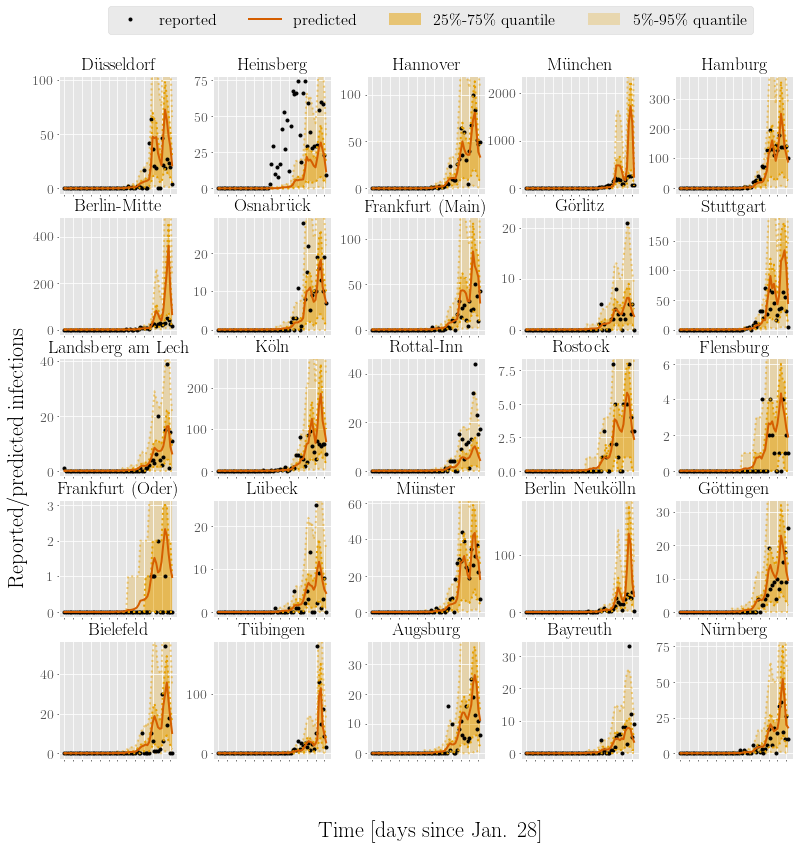

In [10]:
# first plot
p_curves = curves_appendix()
p_curves.show()

A zoom in illustrates for two example the temporal changes including a periodic component with a weekly interval. 

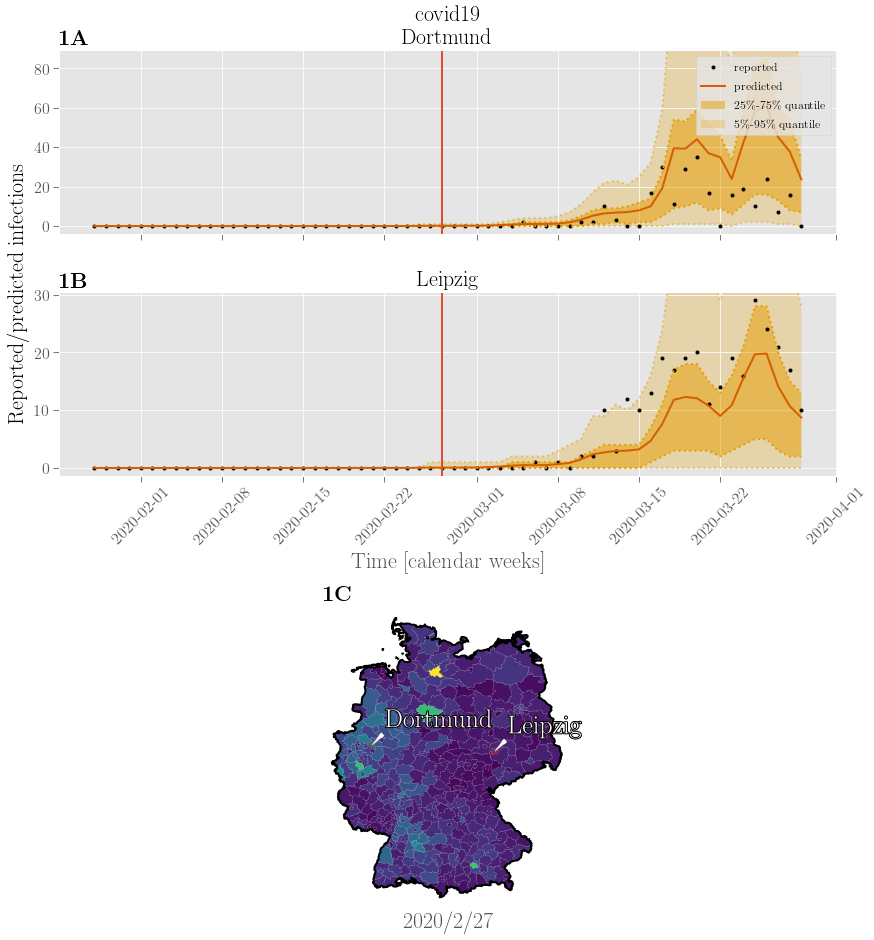

In [11]:
p_curves_map = curves()
p_curves_map.show()

## Model details
We use a probailitic model to fit the observed data (See Details below ).

The model considers two classes of predictive features. Firstly, spatio-temporal features that are functions of space, time or both. These features include the purely temporal trend in the data, a period weekly component that is an artifact by the reporting system, and lasty spatial components that are county specific, such as the region-specific demographics or legislation and differences in policies to react to COVID-19. 

Secondly and most importantly we model a spatio-temporal interaction effect that is modelled as an autoregressive variable that captures how an observed infection influences the number of further infections in its neighborhood over time, which depends on differences in patients’ behavior, transmission vectors, incubation times and duration of the respective diseases. 

Even in the absence of direct contagion, previously reported cases can provide valuable indirect information for predicting future cases through latent variables. The effect on the expected number of cases at a given place and time due to interactions is expressed by spatial and temporal distance to previously reported cases. 

The interaction map allows to assess to what degree a local infection rates are influenced by their neighbors, e.g. smaller counties close to larger cities [2], incorporating the county’s and its neighbors’ recent history of case counts can improve predictions.

The interaction effect is modelled to be identical for all counties.


In [1]:
p_interaction = interaction_kernel()
p_interaction.show()

NameError: name 'interaction_kernel' is not defined

## Interpretation of the Interaction
The average interaction of the COVID-19 outbreak is much localized and relatively fast. A positive component indicating a speed up of infection rate based on infections reported in closer distance is apparent. The spatial component is restricted to the first spatial component basis function with a radius only 6.25km. Additionally the temporal component of the interaction affect is limited to a period of not more than 3 days. 

NEXT step: Dependent on age group and for diffeent periods before after policy changes

## The Model 
The model is probabilistic and described the newly reported cases per day. Since epidemiological count data is often over dispersed relative to a Poisson distribution [3], i.e. the variance exceeds the mean, we assume counts are distributed as a Negative Binomial random variable around an expected value $μ(t, x)$ that varies with time (t) and space (x), 
$$µ(x,t) = e^{ \left ( \sum_{i} w_i basis function(x,t) \right )}$$
As Basis function we use a 4th  to 5th order polynomial to model the trend in the data. 
To account for reporting delays we assume an additional drop of case modelled by basis function with a $f(t)=(t-4)^2 for t>t_max-4$ and zero otherwise. 
To account for weekly periodicity due to systematic affect in the reporting system, we add polynomial of order 4 that is repeats with a period length of 7. 
All these basis functions are linearly weighted with weights estimated by fitting the model to the data using PyMC3.  

The model is finally composed of 9 basis functions for modeling spatio temporal dynamics.




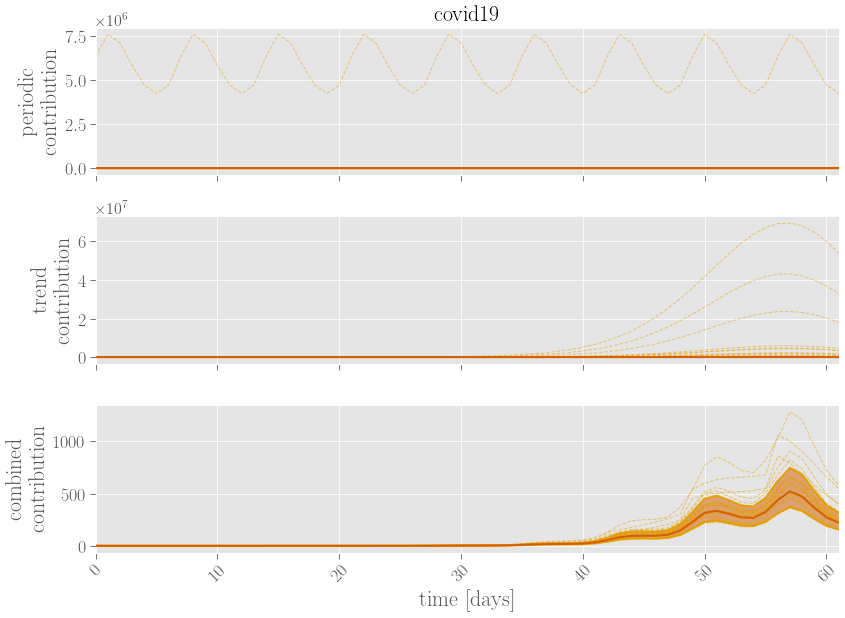

In [14]:
p_temporal_contribution = temporal_contribution()
p_temporal_contribution.show()

## Model for the interaction 

Each reported case provides valuable information about the expected number of cases to come in the near future and close proximity. We suppose that this effect of an individual reported infection on the rate of future (reported) infections in the direct neighborhood can be captured by some unknown function $κ(d_{time}(t⋆, t_k), dgeo(x⋆, xk))$, which we refer to as interaction effect kernel in the following, where $(t_k, x_k)$ refer to the time and location of the k-th reported case and $(t⋆, x⋆)$ represent the time and location of a hypothetical future case. Here, $d_{geo}(x, y)$ represents the geographical distance between two locations x and y, whereas $d_{time}(t, s)$ denotes the time difference between two time points t and s. Thus, $κ(⋅, ⋅)$ is a radial, time- and location-invariant kernel, depending only on the spatial and temporal proximity of the two (hypothetical) cases. For the sake of simplicity, we assume that interaction effects due to individual infections add up linearly.

To bea ble to learn the spatio termporal interaction kernel from the observed data, we approximate the Kernel by a linear combination of spatio-temporal basis kernels $κ_{i,j}$ with coefficients $w_i$ that can be inferred from training data, using the same Monte Carlo procedure as for learning all other parameters of the model. As spatial basis functions we use Gaussian centered at zero with a shpae paremeter (i.e. standard deviation) or 6.25, 12.5, 25 and 50km. The special compoent of the kernelis modelled by a cubic splines with in total 4 basis functiosn covering the interval of 5 days.



## Monte Carlo sampling procedure

The model described above determines the posterior distribution over parameters by the data-dependent likelihood and the choice of priors. We capture this parameter distributions in a fully Bayesian manner. To this end we use Markov Chain Monte Carlo (MCMC) methods to generate unbiased samples of this posterior distribution. These samples can be used for evaluation of performance measures (here deviance and Dawid-Sebastiani score; cf. section Predictive performance evaluation and model selection)..

Our model combines features that can be directly observed (e.g. demographic information) with features that can only be estimated (e.g. interaction effects, due to uncertainty caused by data aggregation). To integrate the latter into the model, we generate samples from the distribution of interaction effects features as outlined in section Interaction effects.

The sampling procedure generates samples from the prior distribution over parameters and combines them with training data and our previously generated samples of the interaction effect features to produce samples of the posterior parameter distribution. These samples from the inferred joint distribution over parameters are then used to generate samples of the posterior distribution of model predictions for testing data.

We employ a Hamiltonian Monte Carlo method, No-U-Turn-Sampling [16], implemented in the probabilistic programming package pyMC3.



#References 
(1) Stojanović, O., Leugering, J., Pipa, G., Ghozzi, S., & Ullrich, A. (2019). A Bayesian Monte Carlo approach for predicting the spread of infectious diseases. PloS one, 14(12).
(2) Xia Y, Bjørnstad O, Grenfell B. Measles Metapopulation Dynamics: A Gravity Model for Epidemiological Coupling and Dynamics. The American Naturalist. 2004;164(2):267–281. pmid:15278849 
(3) Lee JH, Han G, Fulp W, Giuliano A. Analysis of overdispersed count data: application to the Human Papillomavirus Infection in Men (HIM) Study. Epidemiology & Infection. 2012;140(6):1087–1094. 